In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

def convert_volume(vol):
    if pd.isna(vol) or vol == '' or vol == '-':
        return np.nan
    vol = str(vol).replace(',', '')
    if vol.endswith('K'):
        return float(vol[:-1]) * 1_000
    if vol.endswith('M'):
        return float(vol[:-1]) * 1_000_000
    try:
        return float(vol)
    except:
        return np.nan

def initial_clean(df):
    df = df.copy()
    # Chuyển ngày tháng và sắp xếp
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)

    # Chuyển đổi các cột số
    price_cols = ['Price', 'Open', 'High', 'Low']
    for col in price_cols:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    
    df['Vol.'] = df['Vol.'].apply(convert_volume)
    
    # Thiết lập tần suất ngày làm việc (Business days)
    df = df.asfreq('B')
    return df

# 3. Hàm tính Metrics
def get_metrics(true, pred, name):
    true = np.array(true)
    pred = np.array(pred)
    
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)

    # Directional Accuracy (Xu hướng tăng/giảm)
    true_diff = np.sign(true[1:] - true[:-1])
    pred_diff = np.sign(pred[1:] - true[:-1]) # Dự báo t+1 so với thực tế t
    directional_acc = np.mean(true_diff == pred_diff) * 100
    
    print(f"\n[{name}] Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2: {r2:.4f}")
    print(f"Directional Accuracy: {directional_acc:.2f}%")
    return [rmse, mape, r2, directional_acc]


In [2]:
df_raw = pd.read_csv('Gold Price (2013-2023).csv')
df = initial_clean(df_raw)

train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

train_df['Price'] = train_df['Price'].interpolate(method='time').ffill().bfill()

print(f"Pipeline ready. Train: {len(train_df)}, Test: {len(test_df)}")

# 4. Tìm tham số ARIMA tốt nhất trên tập Train
print("Finding best ARIMA parameters...")
stepwise_fit = pm.auto_arima(train_df['Price'], 
                             seasonal=False, 
                             stepwise=True, 
                             suppress_warnings=True, 
                             error_action='ignore')
best_order = stepwise_fit.order
print(f"Best ARIMA Order: {best_order}")

# 5. Recursive Forecasting (Dự báo dựa trên kết quả của chính nó)
history = list(train_df['Price']) 
arima_preds = []
actual_values = []

print("Starting Recursive Forecast (Multi-step ahead)...")
for t in range(len(test_df)):
    # Dự báo bước tiếp theo dựa trên "history" (vốn đang dần bị lấp đầy bởi giá trị dự báo)
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    
    arima_preds.append(yhat)
    
    # Lưu lại giá trị thực tế để so sánh đối chiếu (chỉ dùng để tính metric, không đưa vào history)
    actual = test_df['Price'].iloc[t]
    if pd.isna(actual):
        actual = test_df['Price'].ffill().iloc[t] if t > 0 else history[-1]
    actual_values.append(actual)
    
    # ĐIỂM KHÁC BIỆT CHÍNH: Cập nhật history bằng GIÁ TRỊ DỰ BÁO (yhat)
    history.append(yhat) 

Pipeline ready. Train: 2347, Test: 261
Finding best ARIMA parameters...
Best ARIMA Order: (2, 1, 2)
Starting Recursive Forecast (Multi-step ahead)...



[ARIMA_Recursive] Results:
RMSE: 92.16
MAPE: 4.12%
R2: -0.0182
Directional Accuracy: 53.46%


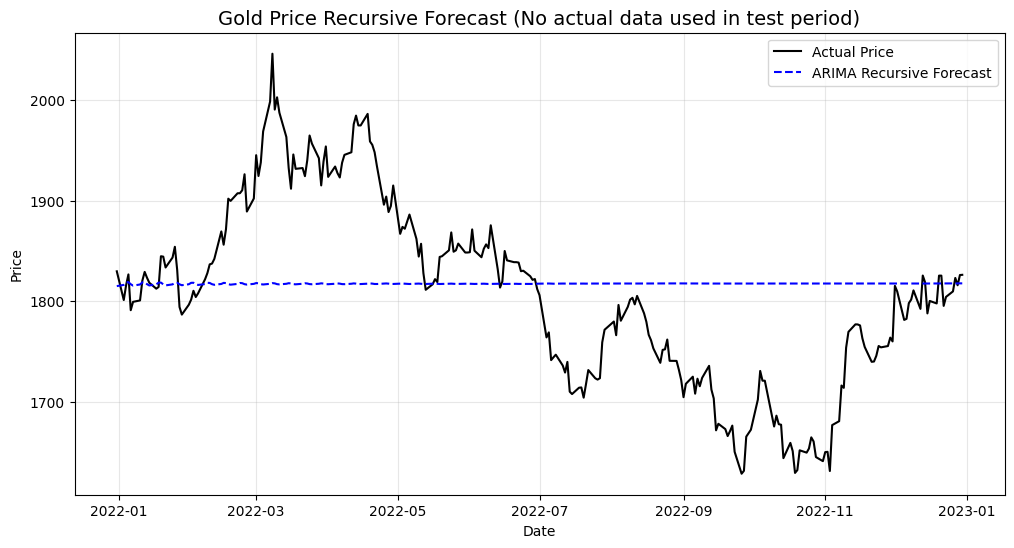

In [3]:
arima_res = get_metrics(actual_values, arima_preds, "ARIMA_Recursive")

plt.figure(figsize=(12, 6))
plt.plot(test_df.index, actual_values, label='Actual Price', color='black', linewidth=1.5)
plt.plot(test_df.index, arima_preds, label='ARIMA Recursive Forecast', color='blue', linestyle='--', linewidth=1.5)
plt.title(f"Gold Price Recursive Forecast (No actual data used in test period)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()